## Introduction to ANN - Exercise
---
Instructions are given in <span style="color:blue">blue</span> color.

Here, there really is just one task: Repeat the training part of the notebook we used in class replacing the MNIST dataset with [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), but also do some experimentation with the MLP-Parameters:
* $n_h$: number of hidden layers,
* $m_j,\>j=1,\dots,n_h$: number of neurons in the $j$-th hidden layer,
* and other hyperparameters that have an impact on performance and training time.

### CIFAR-10

The CIFAR-10 dataset consists of $32 \times 32 \times 3$ RGB pixel images, where each pixel is represented by a RGB value. The third dimension (or *channel* in the case of image data) represents the color value. Therefore, we have $32\times32\times3=3072$ *features* per row. The images are then *unrolled* (or flattened) into vectors of length $3072$ and each one (in both the training set and the test set) is given a *class label* of $0-9$ corresponding to the type of class it represents (where the number corresponds to the alphabetic ordering of the classes).

You fill find the dataset publicly available on [Alex Krizhevsky's Homepage](https://www.cs.toronto.edu/~kriz/cifar.html). To load the data you can use an *adaptation* of the following code from [Matt Petersen](https://mattpetersen.github.io/load-cifar10-with-numpy). Either specify a path and the data will automatically be downloaded, or download the binary version of the data beforehand.
This is done with the following code along with some restructuring in order to be able to work with the data in very much the same way we did with MNIST in class.

**Note**: It might actually take a while to execute the next couple of code cells, especially if the data needs to be downloaded first. Just be patient.

In [17]:
"""Load from /home/USER/data/cifar10 or elsewhere; download if missing."""

import tarfile
import os
from urllib.request import urlretrieve
import numpy as np


def cifar10(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing CIFAR-10. Default is
            /home/USER/data/cifar10 or C:\Users\USER\data\cifar10.
            Create if nonexistant. Download CIFAR-10 if missing.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values,
            with the order (red -> blue -> green). Columns of labels are a
            onehot encoding of the correct class.
    """
    url = 'https://www.cs.toronto.edu/~kriz/'
    tar = 'cifar-10-binary.tar.gz'
    files = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']

    if path is None:
        # Set path to /home/USER/data/cifar10 or C:\Users\USER\data\cifar10
        path = os.path.join(os.path.expanduser('~'), 'data', 'cifar10')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download tarfile if missing
    if tar not in os.listdir(path):
        urlretrieve(''.join((url, tar)), os.path.join(path, tar))
        print("Downloaded %s to %s" % (tar, path))

    # Load data from tarfile
    with tarfile.open(os.path.join(path, tar)) as tar_object:
        # Each file contains 10,000 color images and 10,000 labels
        fsize = 10000 * (32 * 32 * 3) + 10000

        # There are 6 files (5 train and 1 test)
        buffr = np.zeros(fsize * 6, dtype='uint8')

        # Get members of tar corresponding to data files
        # -- The tar contains README's and other extraneous stuff
        members = [file for file in tar_object if file.name in files]

        # Sort those members by name
        # -- Ensures we load train data in the proper order
        # -- Ensures that test data is the last file in the list
        members.sort(key=lambda member: member.name)

        # Extract data from members
        for i, member in enumerate(members):
            # Get member as a file object
            f = tar_object.extractfile(member)
            # Read bytes from that file object into buffr
            buffr[i * fsize:(i + 1) * fsize] = np.frombuffer(f.read(), 'B')

    # Parse data from buffer
    # -- Examples are in chunks of 3,073 bytes
    # -- First byte of each chunk is the label
    # -- Next 32 * 32 * 3 = 3,072 bytes are its corresponding image

    # Labels are the first byte of every chunk
    labels = buffr[::3073]

    # Pixels are everything remaining after we delete the labels
    pixels = np.delete(buffr, np.arange(0, buffr.size, 3073))
    images = pixels.reshape(-1, 3072).astype('float32') / 255

    # Split into train and test
    train_images, test_images = images[:50000], images[50000:]
    train_labels, test_labels = labels[:50000], labels[50000:]

    return train_images, train_labels, test_images, test_labels

In [18]:
X_train, y_train, X_test, y_test = cifar10('./data')
print(f'Train - Rows: {X_train.shape[0]}, columns: {X_train.shape[1]}')
print(f'Test - Rows: {X_test.shape[0]}, columns: {X_test.shape[1]}')

Train - Rows: 50000, columns: 3072
Test - Rows: 10000, columns: 3072


The CIFAR-10 data has a different structure than the MNIST data. To get the same structure as in the class example we need to switch some dimensions and reshape the array.

In [19]:
X_train = (np.moveaxis(X_train.reshape(50000,3,32,32),1,-1)).reshape(50000,3072)
X_test = (np.moveaxis(X_test.reshape(10000,3,32,32),1,-1)).reshape(10000,3072)

In [20]:
X_train.shape[1]

3072

To remove the color channel from our images we have to reshape a little differently.

In [26]:
# Calculating the mean of all 3 channels as the greyscale value:
X_train_g = np.mean(X_train.reshape(50000,32,32,3),-1).reshape(50000,1024)
X_test_g = np.mean(X_test.reshape(10000,32,32,3),-1).reshape(10000,1024)

In [ ]:
X_train_g.shape[1]

1024

* <div style="color:blue">Let's get started with a little visualization task by displaying the 42nd image of each class present.</div>

**Hint**: Remember that you are working with an additional color dimension!

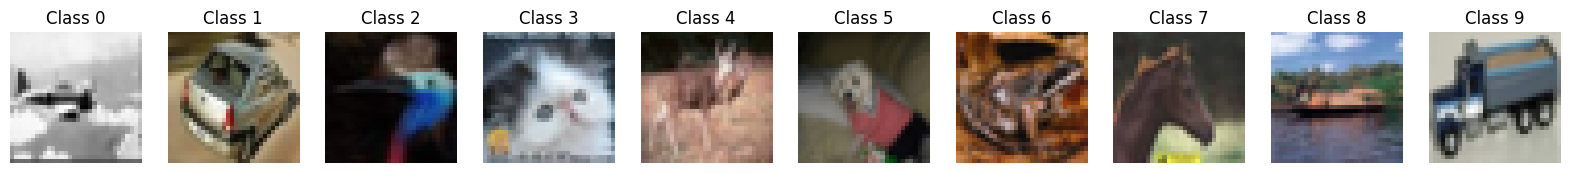

In [32]:
import numpy as np
import matplotlib.pyplot as plt
# Load the CIFAR-10 dataset
train_images, train_labels, test_images, test_labels = cifar10('./data')
# Plotting the 42nd image of each class
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
class_counts = np.zeros(10, dtype=int)

for i in range(len(train_labels)):
    label = train_labels[i]
    class_counts[label] += 1
    if class_counts[label] == 42:
        ax = axes[label]
        ax.imshow(train_images[i])
        ax.axis('off')
        ax.set_title(f'Class {label}')

plt.show()


* <div style="color:blue">Visualize 25 different samples of the class representing dogs.</div>

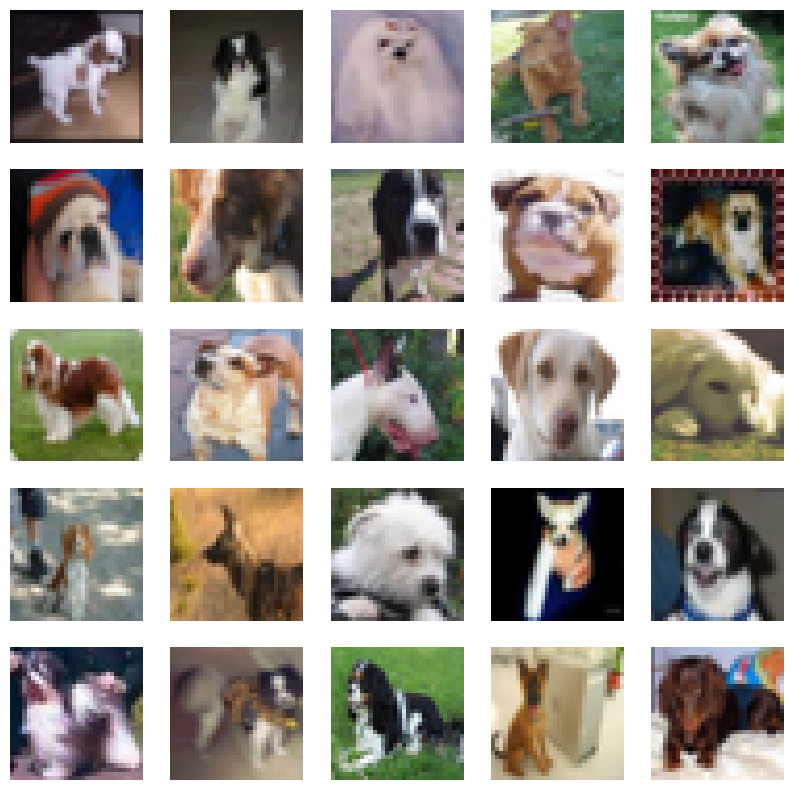

In [33]:
# Your solution goes here:

import numpy as np
import matplotlib.pyplot as plt

# Assuming the data has already been loaded as train_images and train_labels
# Identify indices of dog images
dog_indices = np.where(train_labels == 5)[0]

# Randomly select 25 indices from dog indices
np.random.seed(0)  # For reproducibility
selected_indices = np.random.choice(dog_indices, 25, replace=False)

# Plotting the selected dog images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 subplot for 25 images
axes = axes.flatten()  # Flatten the 2D array of axes to simplify the loop

for i, idx in enumerate(selected_indices):
    axes[i].imshow(train_images[idx])
    axes[i].axis('off')  # Turn off axis numbering

plt.show()


You are now asked to perform image classification using a multi-layer perceptron:

* <div style="color:blue">Use <code>scikit learn</code>'s <code>MLPClassifier</code> to train various models that specify</div>

    * <div style="color:blue">different numbers of hidden layers,</div>
    * <div style="color:blue">different numbers of neurons in the hidden layers,</div>
    * <div style="color:blue">different hyperparameters (see info below).</div>
* <div style="color:blue">For each of your model variants you should record</div>

    * <div style="color:blue">the time it took to train the network,</div>
    * <div style="color:blue">how many epochs were necessary,</div>
    * <div style="color:blue">how the loss values evolved over the epochs,</div>
    * <div style="color:blue">the accuracy of both training and test data.</div>
* <div style="color:blue">What is your <b>interpretation</b> of those experiments? Give a comment on the behaviour of the different MLP configurations.</div>

**Hints**: 
* The CIFAR-10 data is much more complex than MNIST (as seen in class). The image resolution is very small and the classes are much more *nuanced*. In order to successfully classify such data, you might need to tune some parameters of your model.
* Due to the bigger input size, training times might be much slower than you have seen in class. You absolutely should change some hyperparameters that have an impact on the training times (if you don't want to wait for hours). Here are some **ideas** you could try: 
    + `batch_size`: Larger batch sizes mean less gradient updates are computed, but calculating the gradient is more computationally expensive. So there is an inherent trade-off in the magnitude of batch sizes. Not only that, but different batch sizes will have an impact on model performance. Increasing the batch size might lead to a solution that is closer to the true global minimum (which can actually be undesired as the model loses its ability to generalize). On the other hand, decreasing the batch size might get the model stuck at a bad local minimum early on in the training process. For further information see [Goodfellow et al., 2016](http://www.deeplearningbook.org/contents/optimization.html).
    + `learning_rate`: Higher learning rates will reduce the model's convergence time, but can result in suboptimal weight updates towards the end of the learning process (which can lead to increased bias of the model).
    + `hidden_layer_sizes`: Reducing the number of layers and neurons will result in a less complex model and, therefore, faster training times. However, if the model is too simple, it might not be able to fit the data at hand, which results in low accuracy.
    + `max_iter`: You can force an early stop of the training process with this parameter. This is actually a valid strategy to prevent overfitting, but the model might not fit the data yet if you stop too early. Don't be shy to try really low values!
    + **Data Transformation**: Sometimes it can make sense to transform the data to improve training time. You can always train with less data of course, but this might lead to poor performance of the model. For the image classification task, you can also try to train with *greyscale* only, which would reduce input size by 2/3. Maybe the model is mostly invariant to the *color component*?
<br>
<br>
* If you want to see some more information during the training process, you can turn on the `verbose` parameter (recommended!).
* Getting *above* 50% Test-Accuracy in a short amount of training time would be a really good result! Can you do it?

In [36]:
# Your solution goes here: (if you need more code/markdown cells, feel free to insert them as you see fit)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from time import time

In [37]:
#Preparing the CIFAR-10 Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_g)
X_test_scaled = scaler.transform(X_test_g)
#

Iteration 1, loss = 2.13462041
Iteration 2, loss = 1.78997445
Iteration 3, loss = 1.75231361
Iteration 4, loss = 1.72560032
Iteration 5, loss = 1.70969891
Iteration 6, loss = 1.70152886
Iteration 7, loss = 1.68792755
Iteration 8, loss = 1.67115151
Iteration 9, loss = 1.66096177
Iteration 10, loss = 1.64129142
Iteration 11, loss = 1.63450456
Iteration 12, loss = 1.62753377
Iteration 13, loss = 1.61403696
Iteration 14, loss = 1.61058033
Iteration 15, loss = 1.59110711
Iteration 16, loss = 1.59041514
Iteration 17, loss = 1.58081715
Iteration 18, loss = 1.58093589
Iteration 19, loss = 1.56864800
Iteration 20, loss = 1.56177629
Iteration 21, loss = 1.57094844
Iteration 22, loss = 1.53725289
Iteration 23, loss = 1.53764749
Iteration 24, loss = 1.52033652
Iteration 25, loss = 1.51748000
Iteration 26, loss = 1.50951529
Iteration 27, loss = 1.52340931
Iteration 28, loss = 1.49734815
Iteration 29, loss = 1.49941411
Iteration 30, loss = 1.49630529
Iteration 31, loss = 1.49295123
Iteration 32, los

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.29520917
Iteration 2, loss = 1.80650504
Iteration 3, loss = 1.79448752
Iteration 4, loss = 1.75802963
Iteration 5, loss = 1.75860006
Iteration 6, loss = 1.74130756
Iteration 7, loss = 1.73036888
Iteration 8, loss = 1.69752776
Iteration 9, loss = 1.69894323
Iteration 10, loss = 1.66326393
Iteration 11, loss = 1.66005391
Iteration 12, loss = 1.63797668
Iteration 13, loss = 1.63471747
Iteration 14, loss = 1.62451401
Iteration 15, loss = 1.62535372
Iteration 16, loss = 1.60108907
Iteration 17, loss = 1.57020480
Iteration 18, loss = 1.57925284
Iteration 19, loss = 1.57602993
Iteration 20, loss = 1.55329155
Iteration 21, loss = 1.54959215
Iteration 22, loss = 1.52921447
Iteration 23, loss = 1.52284862
Iteration 24, loss = 1.52163829
Iteration 25, loss = 1.50634160
Iteration 26, loss = 1.48758494
Iteration 27, loss = 1.48348529
Iteration 28, loss = 1.45505937
Iteration 29, loss = 1.47476658
Iteration 30, loss = 1.46827190
Iteration 31, loss = 1.46652717
Iteration 32, los

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02374734
Iteration 2, loss = 1.82928983
Iteration 3, loss = 1.76960089
Iteration 4, loss = 1.73060731
Iteration 5, loss = 1.69090251
Iteration 6, loss = 1.66326025
Iteration 7, loss = 1.64375560
Iteration 8, loss = 1.61632625
Iteration 9, loss = 1.60530466
Iteration 10, loss = 1.58609332
Iteration 11, loss = 1.58429981
Iteration 12, loss = 1.55859050
Iteration 13, loss = 1.54967172
Iteration 14, loss = 1.53625812
Iteration 15, loss = 1.52380247
Iteration 16, loss = 1.52052472
Iteration 17, loss = 1.50281876
Iteration 18, loss = 1.49863382
Iteration 19, loss = 1.49195760
Iteration 20, loss = 1.47625225
Iteration 21, loss = 1.47980593
Iteration 22, loss = 1.47179177
Iteration 23, loss = 1.44742353
Iteration 24, loss = 1.45267423
Iteration 25, loss = 1.44487631
Iteration 26, loss = 1.43245048
Iteration 27, loss = 1.43289034
Iteration 28, loss = 1.42782271
Iteration 29, loss = 1.41645607
Iteration 30, loss = 1.40762609
Iteration 31, loss = 1.40184924
Iteration 32, los

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: (64, 64), Test Accuracy: 0.3742, Training Time: 60.33975076675415
Iteration 1, loss = 2.08771037
Iteration 2, loss = 1.87405913
Iteration 3, loss = 1.78655265
Iteration 4, loss = 1.73923958
Iteration 5, loss = 1.71194928
Iteration 6, loss = 1.68284615
Iteration 7, loss = 1.65299647
Iteration 8, loss = 1.64236085
Iteration 9, loss = 1.61460159
Iteration 10, loss = 1.59538141
Iteration 11, loss = 1.57336231
Iteration 12, loss = 1.56125857
Iteration 13, loss = 1.53986430
Iteration 14, loss = 1.53150523
Iteration 15, loss = 1.52388753
Iteration 16, loss = 1.50127447
Iteration 17, loss = 1.48701241
Iteration 18, loss = 1.46532160
Iteration 19, loss = 1.46677535
Iteration 20, loss = 1.44409002
Iteration 21, loss = 1.43036247
Iteration 22, loss = 1.42851371
Iteration 23, loss = 1.39912060
Iteration 24, loss = 1.39307089
Iteration 25, loss = 1.38318665
Iteration 26, loss = 1.37847536
Iteration 27, loss = 1.35686272
Iteration 28, loss = 1.35729970
Iteration 29, loss = 1.34349368
Iterati

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: (128, 64), Test Accuracy: 0.3799, Training Time: 85.5710756778717


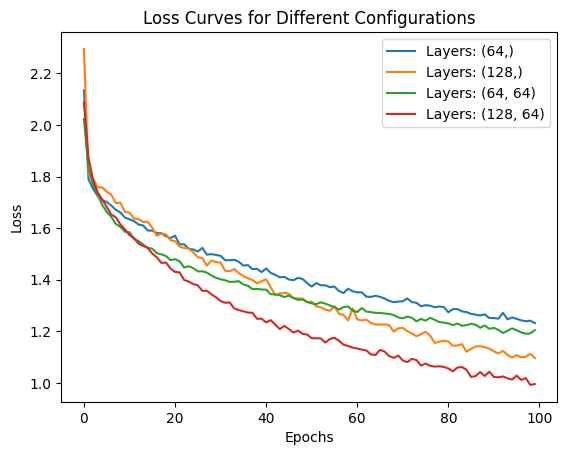

In [39]:
#Setting Up and Train Several MLP Configurations
def train_and_evaluate_mlp(hidden_layer_sizes, max_iter=200, learning_rate_init=0.001, batch_size='auto', verbose=False):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        max_iter=max_iter,
                        learning_rate_init=learning_rate_init,
                        batch_size=batch_size,
                        verbose=verbose,
                        random_state=1)
    
    start_time = time()
    mlp.fit(X_train_scaled, y_train)
    training_time = time() - start_time
    
    # Predictions to calculate accuracy
    y_pred_train = mlp.predict(X_train_scaled)
    y_pred_test = mlp.predict(X_test_scaled)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Collect training loss per iteration
    loss_curve = mlp.loss_curve_
    
    return {
        "training_time": training_time,
        "epochs": len(loss_curve),
        "loss_curve": loss_curve,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy
    }


configurations = [
    (64,),  # One hidden layer with 64 neurons
    (128,),  # One hidden layer with 128 neurons
    (64, 64),  # Two hidden layers with 64 neurons each
    (128, 64),  # Two hidden layers with 128 and 64 neurons
]

results = {}
for config in configurations:
    result = train_and_evaluate_mlp(config, max_iter=100, learning_rate_init=0.01, batch_size=200, verbose=True)
    results[config] = result
    print(f"Config: {config}, Test Accuracy: {result['test_accuracy']}, Training Time: {result['training_time']}")



fig, ax = plt.subplots()
for config, result in results.items():
    ax.plot(result['loss_curve'], label=f"Layers: {config}")
ax.set_title('Loss Curves for Different Configurations')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()



* <div style="color:blue">Visualize 12 misclassifications <b>and</b> state an opinion on these.</div>

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


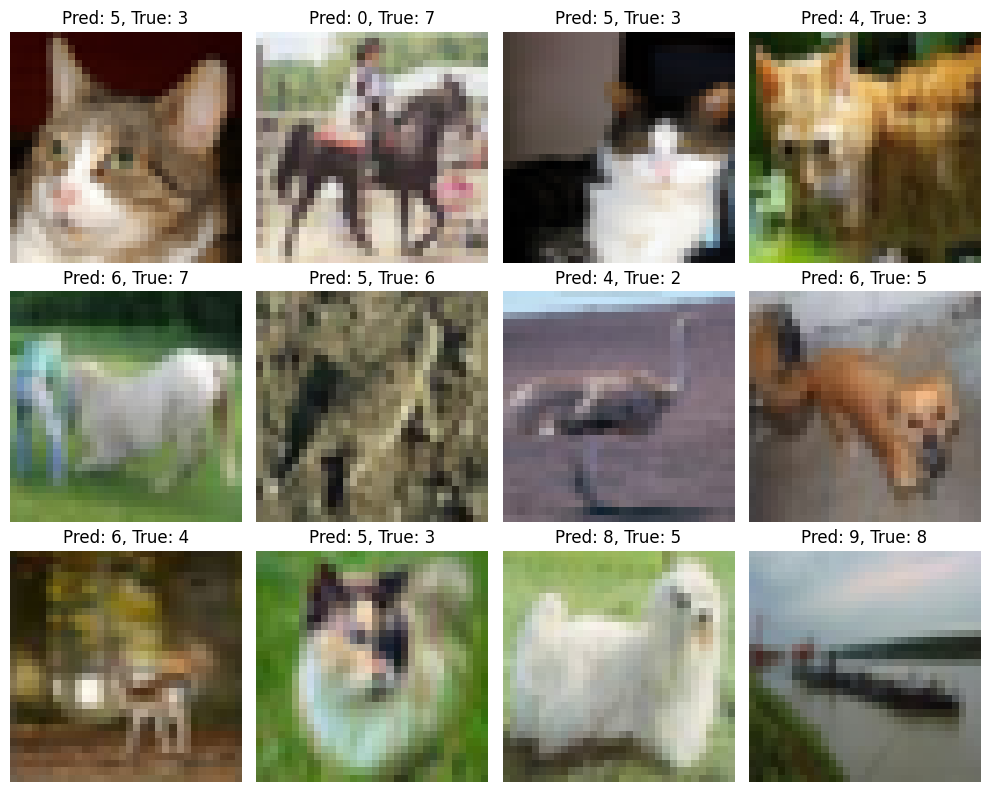

In [40]:
# Your solution goes here: (if you need more code/markdown cells, feel free to insert them as you see fit)

import matplotlib.pyplot as plt
# Randomly choosing one configuration (e.g., (128, 64) layers) for demonstration
chosen_config = (128, 64)
mlp = MLPClassifier(hidden_layer_sizes=chosen_config, max_iter=100, learning_rate_init=0.01, batch_size=200, random_state=1)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_scaled)

# Get indices where predictions and true labels mismatch
misclassified_indices = np.where(y_pred != y_test)[0]



# Randomly select 12 indices from misclassified_indices
np.random.seed(0)
selected_misclassified_indices = np.random.choice(misclassified_indices, 12, replace=False)

# Plotting the misclassified images
fig, axes = plt.subplots(3, 4, figsize=(10, 8))  # 3x4 grid for 12 images
axes = axes.flatten()  # Flatten the 2D array of axes to simplify the loop

for i, idx in enumerate(selected_misclassified_indices):
    ax = axes[i]
    ax.imshow(X_test[idx].reshape(32, 32, 3), cmap='gray')  # Assume X_test was originally reshaped for visualization
    ax.set_title(f"Pred: {y_pred[idx]}, True: {y_test[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()